In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from workalendar.europe import Spain


## Preprocesamiento dataframe clima

In [207]:
# Datos climáticos en crudo
df_clima_raw = pd.read_csv('datos_climaticos_diarios.csv')

In [208]:
# Copia de datos climáticos
df_clima = df_clima_raw.copy()

In [209]:
# Convertir fecha a datetime
if 'fecha' in df_clima.columns:
    df_clima['fecha'] = pd.to_datetime(df_clima['fecha'], errors='coerce')  # Convertir 'fecha' a datetime

# Se comprueba
df_clima.dtypes

fecha      datetime64[ns]
tmed              float64
hrMedia           float64
dtype: object

In [210]:
df_clima.head()

,fecha,tmed,hrMedia
0,2019-01-01,7.546275,64.551332
1,2019-01-02,6.299200,68.139083
2,2019-01-03,5.589226,66.484092
3,2019-01-04,5.572486,64.748375
4,2019-01-05,6.092966,59.188741


## Preprocesamiento dataframe demanda

In [211]:
# Leer el archivo CSV de demanda
df_demanda_raw = pd.read_csv('datos_demanda_media_diaria.csv')

# Seleccionar solo las columnas necesarias
df_demanda = df_demanda_raw.copy()

df_demanda = df_demanda[['datetime_utc', 'Demanda real']]

In [212]:
# Se transforma la columna date al formato datetime
df_demanda['datetime_utc'] = pd.to_datetime(df_demanda['datetime_utc']).dt.strftime('%Y-%m-%d')

In [213]:
df_demanda.head()

,datetime_utc,Demanda real
0,2018-12-31,23459.000000
1,2019-01-01,23083.583333
2,2019-01-02,29587.326389
3,2019-01-03,31287.312500
4,2019-01-04,31500.986111


In [214]:
# Renombrar la columna 'datetime_utc' a 'fecha'
df_demanda.rename(columns={'datetime_utc': 'fecha'}, inplace=True)

# Convertir la columna 'fecha' al tipo datetime64[ns]
df_demanda['fecha'] = pd.to_datetime(df_demanda['fecha'])

# Se comprueba
df_demanda.dtypes

fecha           datetime64[ns]
Demanda real           float64
dtype: object

In [215]:
# Se suma 1 día para evitar errores
# df_demanda['fecha'] = df_demanda['fecha'] + pd.Timedelta(days=1)

## Unificación de ambos dataframe

In [216]:
# Se unen ambos dataframes por la columna fecha
df = pd.merge(df_demanda, df_clima, on='fecha', how='inner')

In [217]:
# Se cambian los nombres de las columnas
df = df.rename(columns={
    'Fecha': 'fecha',
    'Demanda real': 'demanda',
    'tmed': 'tmed',
    'hrMedia': 'hrmedia'
})

# Se comprueba
df.head()

,fecha,demanda,tmed,hrmedia
0,2019-01-01,23083.583333,7.546275,64.551332
1,2019-01-02,29587.326389,6.299200,68.139083
2,2019-01-03,31287.312500,5.589226,66.484092
3,2019-01-04,31500.986111,5.572486,64.748375
4,2019-01-05,28435.444444,6.092966,59.188741


In [218]:
# Ver si falta algún día consecutivo

# Ordenar el DataFrame por la columna 'fecha'
#df = df.sort_values(by='fecha')

# Calcular la diferencia entre fechas consecutivas
#df['diferencia_dias'] = df['fecha'].diff().dt.days

# Encontrar días donde no hay días consecutivos (diferencia > 1)
#días_sin_consecutivos = df[df['diferencia_dias'] > 1]

# Mostrar los días donde no hay consecutivos
#print(días_sin_consecutivos[['fecha', 'diferencia_dias']])

# Si no se encuentran días sin consecutivos
#if días_sin_consecutivos.empty:
#    print("Todos los días están consecutivos.")
#else:
#    print(f"Se encontraron {len(días_sin_consecutivos)} periodos con días no consecutivos.")

## Preprocesamiento dataframe unificado

In [219]:
# Filtrar por años (todos menos el 2024 ya que no está completo)
#df = df[df['fecha'].dt.year != 2024]

In [220]:
# Redondear las columnas a una decimal
df['demanda'] = df['demanda'].round(2)
df['tmed'] = df['tmed'].round(2)
df['hrmedia'] = df['hrmedia'].round(2)

Se añaden las columnas respectivas a las variables exógenas temporales

In [221]:
# Añadir columna para el día de la semana en formato numérico
df['diasem'] = df['fecha'].dt.dayofweek  # 0=lunes, 1=martes, ..., 6=domingo

# Añadir columna para el trimestre en formato numérico de 0 a 3
df['trim'] = df['fecha'].dt.to_period('Q').dt.quarter - 1  # 0=Q1, 1=Q2, 2=Q3, 3=Q4 (invierno primero)

In [222]:
# Crear el calendario de España
cal = Spain()

# Lista para almacenar todos los festivos desde 2019 hasta 2024
festivos_total = []

# Recorrer los años de 2019 a 2024 y obtener los festivos de cada año
for year in range(2019, 2025):
    festivos_anuales = cal.holidays(year)
    festivos_total.extend(festivos_anuales)

# Convertir la lista de festivos en un DataFrame
df_festivos = pd.DataFrame(festivos_total, columns=['fecha', 'nombre_festivo'])

# Convertir las columnas de fecha a formato datetime
df_festivos['fecha'] = pd.to_datetime(df_festivos['fecha'])
df['fecha'] = pd.to_datetime(df['fecha'])

# Combinar el DataFrame original con los festivos por la columna 'fecha'
df = pd.merge(df, df_festivos[['fecha']], on='fecha', how='left')

# Crear una nueva columna 'es_festivo' que será 1 si es festivo, 0 si no lo es
df['festivo'] = df['fecha'].isin(df_festivos['fecha']).astype(int)

In [223]:
# Se cambia el índice a la columna fecha
#df.set_index('fecha', inplace=True)

df.head()

,fecha,demanda,tmed,hrmedia,diasem,trim,festivo
0,2019-01-01,23083.58,7.55,64.55,1,0,1
1,2019-01-02,29587.33,6.30,68.14,2,0,0
2,2019-01-03,31287.31,5.59,66.48,3,0,0
3,2019-01-04,31500.99,5.57,64.75,4,0,0
4,2019-01-05,28435.44,6.09,59.19,5,0,0


## Valores nulos y duplicados

In [224]:
# Contar la cantidad de valores nulos por columna
df.isnull().sum()

fecha      0
demanda    0
tmed       0
hrmedia    0
diasem     0
trim       0
festivo    0
dtype: int64

In [225]:
# Contar la cantidad de filas duplicadas
df.duplicated().sum()

0

## Tratamiento de valores atípicos

C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


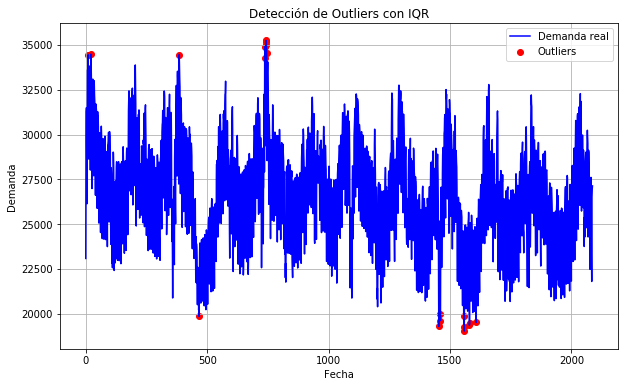

Outliers encontrados:
          fecha   demanda   tmed  hrmedia  diasem  trim  festivo
10   2019-01-11  34446.31   3.15    59.53       4     0        0
21   2019-01-22  34490.67   4.14    78.27       1     0        0
385  2020-01-21  34465.59   4.99    81.12       1     0        0
467  2020-04-12  19845.54  13.84    68.74       6     1        0
737  2021-01-07  34269.90   1.27    83.83       3     0        0
738  2021-01-08  34907.37   1.11    82.21       4     0        0
742  2021-01-12  35252.53   1.92    71.44       1     0        0
743  2021-01-13  35148.13   3.68    70.24       2     0        0
744  2021-01-14  35000.12   3.95    72.52       3     0        0
745  2021-01-15  34542.41   4.89    73.89       4     0        0
1454 2022-12-25  19292.56  12.06    72.91       6     3        1
1460 2022-12-31  20006.33  11.93    60.84       5     3        0
1461 2023-01-01  19617.10  11.79    59.45       6     0        1
1557 2023-04-07  19250.38  13.56    41.99       4     1        1
155

In [226]:
# Cálculo del IQR
Q1 = df['demanda'].quantile(0.25)
Q3 = df['demanda'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para los outliers
limite_inferior = Q1 - 1.2 * IQR
limite_superior = Q3 + 1.2 * IQR

# Detectar outliers
outliers = df[(df['demanda'] < limite_inferior) | (df['demanda'] > limite_superior)]

# Visualización de los outliers
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['demanda'], label='Demanda real', color='blue')
plt.scatter(outliers.index, outliers['demanda'], color='red', label='Outliers')
plt.title('Detección de Outliers con IQR')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.grid(True)
plt.show()

print("Outliers encontrados:")
print(outliers)


C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


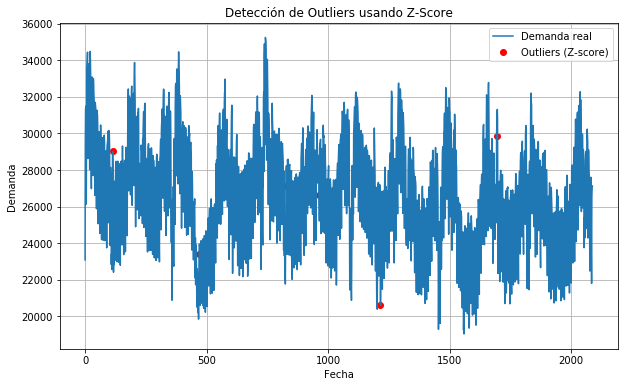

Outliers detectados con Z-Score:
          fecha   demanda   tmed  hrmedia  diasem  trim  festivo
113  2019-04-24  29017.63   9.94    75.55       2     1        0
469  2020-04-14  23411.19  13.64    75.52       1     1        0
826  2021-04-06  27103.62  12.23    55.92       1     1        0
963  2021-08-21  26646.90  23.82    52.68       5     2        0
1215 2022-04-30  20636.17  15.81    61.32       5     1        0
1693 2023-08-21  29866.40  28.08    46.28       0     2        0


In [250]:
# Cálculo de la media móvil y desviación estándar móvil
window = 7  # Ventana de 7 días
rolling_mean = df['demanda'].rolling(window).mean()
rolling_std = df['demanda'].rolling(window).std()

# Cálculo del Z-score
z_scores = (df['demanda'] - rolling_mean) / rolling_std

# Definición de umbral de Z-score para outliers (por ejemplo, 1.2)
outliers_mask = np.abs(z_scores) > 1.7
outliers_mask = outliers_mask & (~(df['diasem'] == 6)) & (~(df['festivo'] == 1))

# Identificar los outliers
outliers_zscore = df[outliers_mask]

# Visualización
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['demanda'], label='Demanda real')
plt.scatter(outliers_zscore.index, outliers_zscore['demanda'], color='red', label='Outliers (Z-score)')
plt.title('Detección de Outliers usando Z-Score')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.grid(True)
plt.show()

print("Outliers detectados con Z-Score:")
print(outliers_zscore)


C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


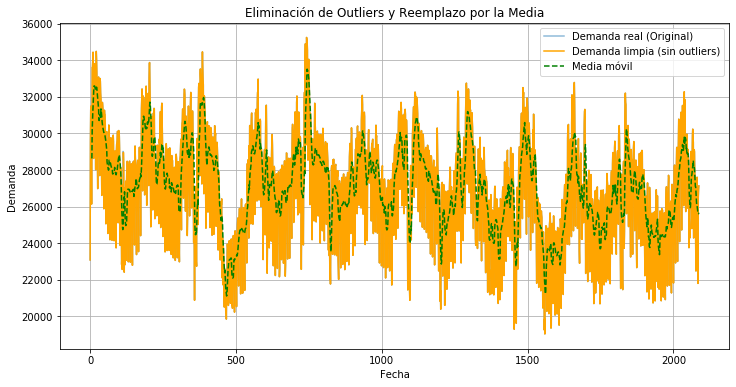

In [251]:
# Crear una copia del DataFrame original
df_cleaned = df.copy()

# Reemplazar los outliers con la media móvil
df_cleaned.loc[outliers_mask, 'demanda'] = rolling_mean[outliers_mask]

# Visualización para comparar los datos originales y los datos limpios
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['demanda'], label='Demanda real (Original)', alpha=0.5)
plt.plot(df_cleaned.index, df_cleaned['demanda'], label='Demanda limpia (sin outliers)', color='orange')
plt.plot(rolling_mean.index, rolling_mean, label='Media móvil', color='green', linestyle='--')

plt.title('Eliminación de Outliers y Reemplazo por la Media')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.grid(True)
plt.show()

In [255]:
df_cleaned.to_csv('datos_preprocesados_sin_outliers.csv', index=False)

In [254]:
df.to_csv('datos_preprocesados.csv', index=False)